# Competition in an oligopolistic market 
## - The Cournot Model

Imports and set magics:

In [104]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#from modelproject import CournotModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Description**

Cournot competition descibes an industry wherein competing firms, who offers identical products. The firms complete via the quantity of output they individually produce, simultaneously and autonomously. This model is named after its founder, the French mathematician Augustin Cournot.

Firstly, we will take a look at the case of a duoploy where only two firms are competing the a given market. the model are given as followed:

$$
\begin{aligned}
\Pi_1(Q) & =p(Q)q_1-q_1MC_1 \\
\Pi_2(Q) & =p(Q)q_2-q_1MC_2 \\
\end{aligned}
$$

In the profit functions provided earlier, price is determined by the total output denoted as $Q$, where for two firms, the total output $Q$ equals the sum of their individual outputs $q_1$ and $q_2$. As an illustrative example, let's assume that the price (expressed as the inverse demand function) follows a linear format, represented by $p = a + bQ$. Consequently, the inverse demand function can be expressed as $p = a + q_1b + q_2b$.

## Analytical solution

The initial segment of this project involves an analytical solution to the Cournot model. Although we acknowledge that this aspect of the project may not be particularly crucial, it is nonetheless essential to include. We utilized the SymPy function for this purpose, and the solution is presented below.

In [105]:
#model = CournotModelClass()


#sol = model.sympy_solve()
#print("Symbolic solution for q1:", sol)

**Setting up with SymPy**

In [106]:
a = sm.symbols('a')
b = sm.symbols('b')
pi_1 = sm.symbols('pi_1')
pi_2 = sm.symbols('pi_2')
mc = sm.symbols('MC')
q1 = sm.symbols('q_1')
q2 = sm.symbols('q_2')
q_star = sm.symbols('q^*')

**Profit functions for each firm**

In [107]:
profit_1 = sm.Eq(pi_1,(a-b*q1-b*q2-mc)*q1)
profit_1

Eq(pi_1, q_1*(-MC + a - b*q_1 - b*q_2))

In [108]:
profit_2 = sm.Eq(pi_2,(a-b*q1-b*q2-mc)*q2)
profit_2

Eq(pi_2, q_2*(-MC + a - b*q_1 - b*q_2))

**FOC for each firm**

In [109]:
#FOC firm 1
profit_1 = (a-b*q1-b*q2-mc)*q1
foc_q1 = sm.diff(profit_1, q1)
foc_q1

-MC + a - 2*b*q_1 - b*q_2

In [110]:
#FOC firm 2
profit_2 = (a-b*q1-b*q2-mc)*q2
foc_q2 = sm.diff(profit_2, q2)
foc_q2

-MC + a - b*q_1 - 2*b*q_2

**Solving for q1 and q2**

In [111]:
#We solve FOC1 for q1
solve_q1 = sm.solve(foc_q1,q1)
solve_q1[0]

(-MC + a - b*q_2)/(2*b)

In [112]:
#We solve FOC2 for q2
solve_q2 = sm.solve(foc_q2,q2)
solve_q2[0]

(-MC + a - b*q_1)/(2*b)

In [113]:
solve_q1_subs = solve_q1[0].subs(q2,q_star)
solve_q1_subs

(-MC + a - b*q^*)/(2*b)

In [114]:
solve_q2_subs = solve_q2[0].subs(q1,q_star)
solve_q2_subs

(-MC + a - b*q^*)/(2*b)

In [115]:
nash_eq = sm.Eq(q_star,solve_q1_subs)
nash_eq

Eq(q^*, (-MC + a - b*q^*)/(2*b))

In [116]:
nash_eq_solve = sm.solve(nash_eq,q_star)
nash_eq_solve[0]

(-MC + a)/(3*b)

Using SymPy, we derived the response functions for both firms and determined the Nash Equilibrium, which is:

$$
\begin{aligned}
\ q_1 = q_2 = \frac{a - bq^*-MC}{2b} \
\end{aligned}
$$
$$
\begin{aligned}
\ Nash & = \frac{a - MC}{3b} \
\end{aligned}
$$

**Creating functions using Lamdify**

After utilizing SymPy to derive the solution, we will employ lambdify to convert these  expressions into callable functions. By doing so, we can efficiently evaluate these expressions using specific numerical values, facilitating numerical analysis and computation

In [117]:
best_resp_q1 = sm.lambdify(args=(a,b,mc),expr=solve_q1[0])
best_resp_q2 = sm.lambdify(args=(a,b,mc),expr=solve_q2[0])
nash_qstar = sm.lambdify(args=(a,b,mc),expr=nash_eq_solve[0])

In [118]:
a_val = 50
b_val = 3
mc_vec = np.linspace(1,10,10)

nash_eq = nash_qstar(a_val, b_val, mc_vec)

for mc, n in zip(mc_vec, nash_eq):
    print(f'For mc = {mc:1.1f}, we have q* = {n:1.3f}')


For mc = 1.0, we have q* = 5.444
For mc = 2.0, we have q* = 5.333
For mc = 3.0, we have q* = 5.222
For mc = 4.0, we have q* = 5.111
For mc = 5.0, we have q* = 5.000
For mc = 6.0, we have q* = 4.889
For mc = 7.0, we have q* = 4.778
For mc = 8.0, we have q* = 4.667
For mc = 9.0, we have q* = 4.556
For mc = 10.0, we have q* = 4.444


## Numerical solution

Once the analytical solution has been obtained, we will proceed to solve the model numerically. Initially, we will employ an optimizer followed by a root finder to determine the quantities for the two firms. Before doing so we need to define a function (H_duo) that computes the errors in the Nash equilibrium conditions for a duopoly model. This function calculates the difference between each firm's best response quantity and its actual quantity produced. Then, it uses an optimization algorithm (optimize.root) to find the Nash equilibrium quantities, starting from an initial guess of [0.1, 0.1]. Below, you will find the relevant code for this numerical solution process.

In [119]:
# Defining the profit function for firm 1
def profit_1_duo(a,b,q1,q2,mc):
        return (a-b*q1-b*q2-mc)*q1

# Defining the best respons function for firm 1
def BR1_duo(q2,a,b,mc):
       sol_BR1_duo = optimize.minimize(lambda q: -profit_1_duo(a,b,q,q2,mc),x0=0.1,bounds=[(0, None)])
       return sol_BR1_duo.x[0]

# Defining the profit function for firm 2       
def profit_2_duo(a,b,q1,q2,mc):
        return (a-b*q1-b*q2-mc)*q2

# Defining the best respons function for firm 2
def BR2_duo(q1,a,b,mc):
       sol_BR2_duo = optimize.minimize(lambda q: -profit_2_duo(a,b,q1,q,mc),x0=0.1,bounds=[(0, None)])
       return sol_BR2_duo.x[0]

# Defining the h_duo function which computes the errors in Nash EQ
def H_duo(q, a, b, mc):
    q1,q2 = q
    err1 = BR1_duo(q2,a,b,mc)-q1
    err2 = BR2_duo(q1,a,b,mc)-q2
    return [err1, err2]

a = 50
b = 3
mc_duo = 1

# Solving for the Nash EQ
result_duo = optimize.root(lambda q: H_duo(q, a, b, mc_duo), [0.1, 0.1])

# Extracting the quantities
q_star = result_duo.x
q1_star, q2_star = q_star
total_output = q1_star + q2_star

print("Nash Equilibrium for mc1 = mc2 = {:.0f}".format(mc_duo))
print("q1* = {:.3f}".format(q1_star))
print("q2* = {:.3f}".format(q2_star))
print("Total Output = {:.3f}".format(total_output))


Nash Equilibrium for mc1 = mc2 = 1
q1* = 5.444
q2* = 5.444
Total Output = 10.889


By experimenting with the value of MC within the range of 1 to 5, you will observe that both the analytical and numerical solutions yield identical results, indicating a promising consistency between the two methods.

To illustarte this, we will plot the solution below.

In [120]:
a = 50
b = 3
mc_default = 5

result = optimize.root(lambda q: H_duo(q, a, b, mc_default), [0.1, 0.1])
q_star = result.x
q1_star, q2_star = q_star

q_values = np.linspace(0, 15, 100)

def update_plot(mc=mc_default):
    q1_values = [BR1_duo(q2, a, b, mc) for q2 in q_values]
    q2_values = [BR2_duo(q1, a, b, mc) for q1 in q_values]
    
    result = optimize.root(lambda q: H_duo(q, a, b, mc), [0.1, 0.1])
    q_star = result.x
    q1_star, q2_star = q_star
    
    plt.figure(figsize=(8, 6))
    plt.plot(q1_values, q_values, label='Best Response Firm 1', color='blue')
    plt.plot(q_values, q2_values, label='Best Response Firm 2', color='red')
    plt.scatter(q1_star, q2_star, color='green', label='Nash Equilibrium')
    plt.plot([q1_star, q1_star], [0, q2_star], color='green', linestyle='--')
    plt.plot([0, q1_star], [q2_star, q2_star], color='green', linestyle='--')
    plt.text(q1_star, q2_star + 0.5, f'({q1_star:.2f}, {q2_star:.2f})', horizontalalignment='center')
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xlabel('q1')
    plt.ylabel('q2')
    plt.title('Best Response Functions and Nash Equilibrium')
    plt.legend()
    plt.grid(True)
    plt.show()

widgets.interact(update_plot, mc=(1, 30, 1))


interactive(children=(IntSlider(value=5, description='mc', max=30, min=1), Output()), _dom_classes=('widget-in…

<function __main__.update_plot(mc=5)>

We've incorporated a slider for the marginal cost (MC) to demonstrate how changes in firms' marginal costs affect the solution of the model. As anticipated, when firms face rising marginal costs, their total output decreases.

In [121]:
#%matplotlib widget

#def tot_profit_duo(q, a, b, mc):
    #q1, q2 = q
    #return profit_1_duo(a, b, q1, q2, mc) + profit_2_duo(a, b, q1, q2, mc)

#profit_star = tot_profit_duo(q_star, a, b, mc)

#q1_range = np.linspace(0, 20, 100)
#q2_range = np.linspace(0, 20, 100)
#q1, q2 = np.meshgrid(q1_range, q2_range)
#profit = tot_profit_duo([q1, q2], a, b, mc)

#profit[profit < 0] = np.nan

#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(q1, q2, profit, cmap='viridis', alpha=0.7)
#ax.scatter(q1_star, q2_star, profit_star, color='red', label='Nash Equilibrium')
#ax.set_xlabel('q1')
#ax.set_ylabel('q2')
#ax.set_zlabel('Total Profit')
#ax.set_title('Cournot Model')

# Annotate Nash equilibrium point
#ax.text(q1_star, q2_star, profit_star, f'({q1_star:.2f}, {q2_star:.2f}, {profit_star:.2f})', color='black')

#ax.legend()
#plt.show()

# Further analysis

The Cournot model can be extended to "n" firms. For our project, we'll concentrate on the case involving three firms in the market, forming an oligopoly. Additionally, we'll make one more extention to the model by making the marginal cost a function of the quantity produced by each firm.

Here's the modified Cournot model:

**The model**

$$
\begin{aligned}
\pi_i(q_1,....,q_n) & =q_iP \left( \sum_{j=1}^{n}q_j\right)-MC_i(q_i) \\

\end{aligned}
$$
  

**Adding another firm - From duopoly to oligopoly**

We start by adapting the model to a oligopoly scenario by adding a profit function and a best response function for Firm 3. This alters the profit functions for Firm 1 and 2, as they now have to take into account the quantity produced by Firm 3. This also effects the best response functions of the three firms as we see below and also the H-function. However, aside from this, the method is the same as used in the numerical solution with the duopol above. 

In [122]:
# We define the profit function and Best Response function for firm 1:
def profit_1_oligo(a,b,q1,q2,q3,mc):
    return (a-b*q1-b*q2-b*q3-mc)*q1

def BR1_oligo(q2,q3,a,b,mc):
    sol_BR1_oligo = optimize.minimize(lambda q: -profit_1_oligo(a,b,q,q2,q3,mc), x0=0.1, bounds=[(0, None)])
    return sol_BR1_oligo.x[0]  

# We define the profit function and Best Response function for firm 2:
def profit_2_oligo(a,b,q1,q2,q3,mc):
    return (a-b*q1-b*q2-b*q3-mc)*q2

def BR2_oligo(q1, q3, a, b, mc):
    sol_BR2_oligo = optimize.minimize(lambda q: -profit_2_oligo(a,b,q1,q,q3,mc), x0=0.1, bounds=[(0, None)])
    return sol_BR2_oligo.x[0]

# We define the profit function and Best Response function for firm 3 that makes it and oligopoly:
def profit_3_oligo(a,b,q1,q2,q3,mc):
    return (a-b*q1-b*q2-b*q3-mc)*q3

def BR3_oligo(q1,q2,a,b,mc):
    sol_BR3_oligo = optimize.minimize(lambda q: -profit_3_oligo(a,b,q1,q2,q,mc), x0=0.1, bounds=[(0, None)])
    return sol_BR3_oligo.x[0]

# We adjust the H-function to take into account Firm 3 as it is now returning err3 aswell:
def H_oligo(q,a,b,mc):
    q1, q2, q3 = q
    err1 = BR1_oligo(q2,q3,a,b,mc)-q1
    err2 = BR2_oligo(q1,q3,a,b,mc)-q2
    err3 = BR3_oligo(q1,q2,a,b,mc)-q3
    return [err1, err2, err3]

# We set the parameters as we have done previously to se the effect of adding another firm to the market
a = 50
b = 3
mc_oligo = 1

# We use optimize.root to solve for the equilibrium quantities and extract them 
result_oligo = optimize.root(lambda q: H_oligo(q,a,b,mc_oligo), [0.1, 0.1, 0.1])

q_star_oligo = result_oligo.x
q1_star_oligo, q2_star_oligo, q3_star_oligo = q_star_oligo
total_output_oligo = q1_star_oligo + q2_star_oligo + q3_star_oligo

print(f'Nash Equilibrium for mc1 = mc2 = mc3 = {mc_oligo:.0f}')
print(f'q1* = {q1_star_oligo:1.3f}')
print(f'q2* = {q2_star_oligo:1.3f}')
print(f'q3* = {q3_star_oligo:1.3f}')
print(f'For mc = {mc_oligo:.0f}, the total output in an oligopoly with three firms is: {total_output_oligo:1.3f}')

Nash Equilibrium for mc1 = mc2 = mc3 = 1
q1* = 4.083
q2* = 4.083
q3* = 4.083
For mc = 1, the total output in an oligopoly with three firms is: 12.250


**Oligopoly with individual marginal costs**

Next up we want to add to the analysis the effects of marginal costs positively related to the individual quantities produced by the firms. For the optimize problem, we use the nelder-mead method. We have tried with a few other methods, but found that the Nelder-Mead gave the best result, as the bounds provided in the problem ensure that the solution remains within feasible regions (non-negative quantities for production). In this case, the lower bound of 0 ensures that negative quantities are not considered as solutions.

In [123]:
#We define the functions for the firm individual marginal costs
def mc1(q1):
    return 1.1+(3*q1)

def mc2(q2):
    return 5+(3*q2)

def mc3(q3):
    return 3+(1.5*q3)

#We adapt the profit functions and Best Response functions for the three firms to account for the marginal cost functions depending on q
def profit_1_mc_var(a,b,q1,q2,q3,mc1):
    return (a-(q1+q2+q3)*b-mc1)*q1

def BR1_mc_var(q2,q3,a,b,mc1):
    sol_BR1_mc_var = optimize.minimize(lambda q: -profit_1_mc_var(a,b,q,q2,q3,mc1), x0=0.1, bounds=[(0, None)])
    return sol_BR1_mc_var.x[0]  


def profit_2_mc_var(a,b,q1,q2,q3,mc2):
    return (a-(q1+q2+q3)*b-mc2)*q2

def BR2_mc_var(q1,q3,a,b,mc2):
    sol_BR2_mc_var = optimize.minimize(lambda q: -profit_2_mc_var(a,b,q1,q,q3,mc2), x0=0.1, bounds=[(0, None)])
    return sol_BR2_mc_var.x[0]


def profit_3_mc_var(a,b,q1,q2,q3,mc3):
    return (a-(q1+q2+q3)*b-mc3)*q3

def BR3_mc_var(q1,q2,a,b,mc3):
    sol_BR3_mc_var = optimize.minimize(lambda q: -profit_3_mc_var(a,b,q1,q2,q,mc3), x0=0.1, bounds=[(0, None)])
    return sol_BR3_mc_var.x[0]

#We define the H-function to take into account the individual q
def H_mc_var(q,a,b,mc1,mc2,mc3):
    q1, q2, q3 = q
    err1 = BR1_mc_var(q2,q3,a,b,mc1)-q1
    err2 = BR2_mc_var(q1,q3,a,b,mc2)-q2
    err3 = BR3_mc_var(q1,q2,a,b,mc3)-q3
    return [err1, err2, err3]

# We set the parameters as previously
a = 50
b = 3

# We formulate the Cournot equilibrium problem as a minimization problem using the optimize.minimize function. 
# It minimizes the sum of squares of the errors in the system of equations, while we set the bounds to include only positive solutions.
result_mc_var = optimize.minimize(lambda q: np.sum(np.square(H_mc_var(q,a,b, mc1(q[0]), mc2(q[1]), mc3(q[2])))),
                           x0=[0.1, 0.1, 0.1], bounds=[(0, None), (0, None), (0, None)], method='nelder-mead')

# We extract equilibrium quantities
q_star_mc_var = result_mc_var.x
q1_star_mc_var, q2_star_mc_var, q3_star_mc_var = q_star_mc_var
total_output_mc_var = q1_star_mc_var + q2_star_mc_var + q3_star_mc_var

print("Nash Equilibrium:")
print(f'q1* = {q1_star_mc_var:1.3f}')
print(f'q2* = {q2_star_mc_var:1.3f}')
print(f'q3* = {q3_star_mc_var:1.3f}')
print(f'In an oligopoly with firm individual and variable MC, the total output is: {total_output_mc_var:1.3f}')

Nash Equilibrium:
q1* = 3.257
q2* = 2.607
q3* = 3.921
In an oligopoly with firm individual and variable MC, the total output is: 9.785


We see, that marginal costs for each firm that initially larger than 1 result in less output for each firm as we would expect. Looking closer at the firms, we see:
* a larger initial marginal cost result in a smaller output for companies with the same increase in mc per quantity of output (comparing firm 1 and 2).
* a relatively smaller increase in mc per quantity of output can have a significant effect on the overall output, as mc is kept low (comparing firm 1 and 3).

In [124]:
#def mc1(q1):
    #return 1+(3*q1)

#def mc2(q2):
    #return 5+(3*q2)

#def mc3(q3):
    #return 3+(1.5*q3)


#def profit_1_mc_var(a, b, q1, q2, q3, mc1):
    #return (a - b * q1 - b * q2 - b * q3 - mc1) * q1

#def BR1_mc_var(q2, q3, a, b, mc1):
    #sol_BR1_mc_var = optimize.minimize(lambda q: -profit_1_mc_var(a, b, q, q2, q3, mc1), x0=0.1, bounds=[(0, None)])
    #return sol_BR1_mc_var.x[0]  


#def profit_2_mc_var(a, b, q1, q2, q3, mc2):
    #return (a - b * q1 - b * q2 - b * q3 - mc2) * q2

#def BR2_mc_var(q1, q3, a, b, mc2):
    #sol_BR2_mc_var = optimize.minimize(lambda q: -profit_2_mc_var(a, b, q1, q, q3, mc2), x0=0.1, bounds=[(0, None)])
    #return sol_BR2_mc_var.x[0]


#def profit_3_mc_var(a, b, q1, q2, q3, mc3):
    #return (a - b * q1 - b * q2 - b * q3 - mc3) * q3

#def BR3_mc_var(q1, q2, a, b, mc3):
    #sol_BR3_mc_var = optimize.minimize(lambda q: -profit_3_mc_var(a, b, q1, q2, q, mc3), x0=0.1, bounds=[(0, None)])
    #return sol_BR3_mc_var.x[0]

# Define function H(q)
#def H_mc_var(q, a, b, mc1, mc2, mc3):
    #q1, q2, q3 = q
    #err1 = BR1_mc_var(q2, q3, a, b, mc1) - q1
    #err2 = BR2_mc_var(q1, q3, a, b, mc2) - q2
    #err3 = BR3_mc_var(q1, q2, a, b, mc3) - q3
    #return [err1, err2, err3]

# Set parameters
#a = 50
#b = 3

#result = optimize.root(lambda q: H_mc_var(q, a, b, mc1, mc2, mc3), [0.1, 0.1, 0.1], method='hybr')

# Extract equilibrium quantities
#q1_star, q2_star, q3_star = result.x
#total_output = q1_star + q2_star + q3_star

# Print results
#print("Nash Equilibrium:")
#print(f'q1* = {q1_star:1.3f}')
#print(f'q2* = {q2_star:1.3f}')
#print(f'q3* = {q3_star:1.3f}')
#print(f'In an oligopoly with firm individual and variable MC, the total output is: {total_output:1.3f}')

# Conclusion

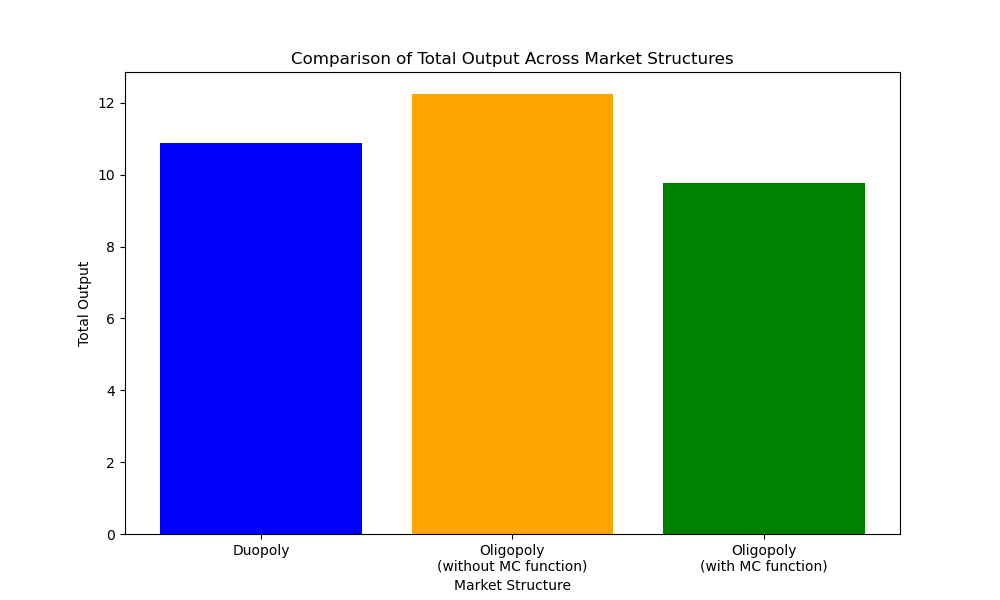

In [125]:
# Define parameters
a = 50
b = 3
mc_duo = 1
mc = 1

# Calculate quantities for each case
duopoly_q1_star, duopoly_q2_star, duopoly_total_output = duopoly_case(a, b, mc_duo)
oligopoly_q1_star, oligopoly_q2_star, oligopoly_q3_star, oligopoly_total_output = oligopoly_case(a, b, mc)
oligopoly_mc_var_q1_star, oligopoly_mc_var_q2_star, oligopoly_mc_var_q3_star, oligopoly_mc_var_total_output = oligopoly_case_mc_var(a, b)

# Create a bar plot
labels = ['Duopoly', 'Oligopoly\n(without MC function)', 'Oligopoly\n(with MC function)']
outputs = [duopoly_total_output, oligopoly_total_output, oligopoly_mc_var_total_output]

plt.figure(figsize=(10, 6))
plt.bar(labels, outputs, color=['blue', 'orange', 'green'])
plt.xlabel('Market Structure')
plt.ylabel('Total Output')
plt.title('Comparison of Total Output Across Market Structures')
plt.show()

The bar plot illustrates the total output across various market structures: duopoly, oligopoly without the marginal cost function, and oligopoly with the marginal cost function.

+ In the duopoly case, where only two firms compete, the total output is moderate compered to the other two, reflecting the balance of competition between the two firms.

+ In contrast, the total output significantly increases in the oligopoly cases, where three firms compete. In the oligopoly without the marginal cost function leads to a slightly higher total output compared to the duopoly case. This suggests that while the addition of a third firm enhances competition and output, the individual output for each firm is slighly lower compered to the duopoly case.

+ Interestingly, when incorporating the marginal cost function in the oligopoly case, the total output further decreases, falling below both the duopoly and oligopoly cases without the marginal cost function. This highlights the importance of considering the marginal cost dynamics in modeling oligopolistic competition, as firms adjust their production levels based on cost considerations.

In summary, the figure demonstrates how different market structures and the incorporation of marginal cost dynamics can impact the total output in an industry. Understanding these dynamics is crucial for analyzing market behavior and making informed policy decisions.

**Acknowledging the Stackelberg Model Extension**

We could have expanded our analysis to include the Stackelberg model, where one firm acts as a leader and sets both price and quantity, while the other firm, the follower, adjusts its output accordingly. In this model, the leader typically enjoys higher profits, benefiting from its first-mover advantage. However, the follower may experience reduced profits due to the competitive response required. This extension would have provided insights into leadership dynamics and their impact on profitability in oligopolistic markets